## Generative Adversarial Network
___
#### Description:
This notebook for the most part follows an example from the Udemy course "Complete Guide to TensorFlow for Deep Learning with Python" section on GANs. This GAN is fed images from the MNIST dataset to generate new images that resemble those from the dataset. It works by having a generator network and a discriminator network compete with one another. The generator is tasked to generate new images and it is the discriminators job to tell if the generated image is fake or real.
___
#### Dataset:

The MNIST dataset of handwritten numbers is used.
___
#### References:
Aside from the Udemy course, I looked at https://github.com/soumith/ganhacks for ideas on how to improve training performance, and I also read  https://deeplearning4j.org/generative-adversarial-network for more information on GANs.

In [1]:
# Import dependencies
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\Marvin\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import the dataset
from tensorflow.examples.tutorials.mnist import input_data

# Read the dataset
dataset = input_data.read_data_sets('../Datasets/MNIST/')

# Printing the dataset shape
print('X train:', dataset.train.images.shape)
print('X test:', dataset.test.images.shape)
print('y train:', dataset.train.labels.shape)
print('y test:', dataset.test.labels.shape)

# NOTE: Pixel values have already been preprocessed to lie between 0 and 1

Extracting ../Datasets/MNIST/train-images-idx3-ubyte.gz
Extracting ../Datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting ../Datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../Datasets/MNIST/t10k-labels-idx1-ubyte.gz
X train: (55000, 784)
X test: (10000, 784)
y train: (55000,)
y test: (10000,)


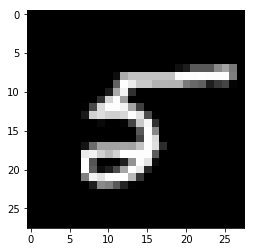

In [3]:
# Display a random training example
rand_idx = np.random.randint(dataset.train.num_examples)
plt.imshow(dataset.train.images[rand_idx].reshape(28, 28), cmap='gray')

In [4]:
# Generator function
def generator(z, reuse=None):
    with tf.variable_scope('gen', reuse=reuse):
        hidden1 = tf.nn.leaky_relu(tf.layers.dense(inputs=z, units=128), alpha=0.2)
        hidden2 = tf.nn.leaky_relu(tf.layers.dense(inputs=hidden1, units=128), alpha=0.2)
        output = tf.layers.dense(inputs=hidden2, units=784, activation=tf.nn.tanh)
    return output

In [5]:
# Discriminator function
def discriminator(X, reuse=None):
    with tf.variable_scope('dis', reuse=reuse):
        hidden1 = tf.nn.leaky_relu(tf.layers.dense(inputs=X, units=128), alpha=0.2)
        hidden2 = tf.nn.leaky_relu(tf.layers.dense(inputs=hidden1, units=128), alpha=0.2)
        logits = tf.layers.dense(inputs=hidden2, units=1)
    return logits

In [6]:
# Placeholders
real_images = tf.placeholder(tf.float32, [None, 784])
z = tf.placeholder(tf.float32, [None, 100])

In [7]:
# Construct generator graph
G = generator(z)

In [8]:
# Construct discriminator graph and combined graph
D_logits_real = discriminator(real_images)
D_logits_fake = discriminator(G, reuse=True)

In [9]:
# Loss function
def loss_func(logits, labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

In [10]:
# Discriminator loss with smoothing
D_real_loss = loss_func(D_logits_real, tf.random_uniform(tf.shape(D_logits_real), minval=0.7, maxval=1.2))
D_fake_loss = loss_func(D_logits_fake, tf.random_uniform(tf.shape(D_logits_fake), minval=0.0, maxval=0.3))

D_loss = (D_real_loss + D_fake_loss)

In [11]:
# Generator loss with smoothing
G_loss = loss_func(D_logits_fake, tf.random_uniform(tf.shape(D_logits_fake), minval=0.7, maxval=1.2))

In [12]:
# List of trainable varibles
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'dis' in var.name]
g_vars = [var for var in tvars if 'gen' in var.name]

In [13]:
# Inspect discriminator variables
d_vars

[<tf.Variable 'dis/dense/kernel:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/kernel:0' shape=(128, 128) dtype=float32_ref>,
 <tf.Variable 'dis/dense_1/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/kernel:0' shape=(128, 1) dtype=float32_ref>,
 <tf.Variable 'dis/dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [14]:
# Constants/Hyperparameters
batch_size = 128
epochs = 200
learning_rate = 2e-4

In [15]:
# Optimizer for discriminator
D_trainer = tf.train.AdamOptimizer(learning_rate).minimize(D_loss, var_list=d_vars)

In [16]:
# Optimizer for generator (discriminator weights do not get updated)
G_trainer = tf.train.AdamOptimizer(learning_rate).minimize(G_loss, var_list=g_vars)

In [17]:
# Create a saver
saver = tf.train.Saver()

In [18]:
# Create a session
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Training
    for epoch in range(epochs):
        
        num_batches = dataset.train.num_examples // batch_size
        
        for i in range(num_batches):
            
            batch_images, _ = dataset.train.next_batch(batch_size)            
            batch_images = batch_images * 2 - 1 # make pixel values between (-1, 1)            
            batch_z = np.random.normal(0, 1, size=(batch_size, 100))
                
            # Training step
            sess.run(D_trainer, feed_dict={real_images: batch_images, z: batch_z})
            sess.run(G_trainer, feed_dict={z: batch_z})
        
        # Evaluate loss every 10 epochs
        if epoch % 10 == 0:
            D_loss_val = D_loss.eval(feed_dict={real_images: batch_images, z: batch_z})
            G_loss_val = G_loss.eval(feed_dict={z: batch_z})
            print('Epoch {}:\tD_loss={},\tG_loss={}'.format(epoch, D_loss_val, G_loss_val))        
            
            # Save generated images every 10 epochs
            sample_z = np.random.normal(0, 1, size=(25, 100))
            gen_sample = sess.run(generator(z, reuse=True), feed_dict={z: sample_z})
            gen_sample = 0.5 * gen_sample + 0.5 # make pixel values between (0, 1)
            
            fig, ax = plt.subplots(5, 5)
            count = 0
            for i in range(5):
                for j in range(5):
                    ax[i, j].imshow(gen_sample[count].reshape(28, 28), cmap='gray')
                    ax[i, j].axis('off')
                    count += 1
            fig.savefig('images/epoch_%d.png' % epoch)
            plt.close()
        
    # Save the session
    saver.save(sess, './gan_session.ckpt')

Epoch 0:	D_loss=0.6600810289382935,	G_loss=1.4707157611846924
Epoch 10:	D_loss=0.8271271586418152,	G_loss=1.2036936283111572
Epoch 20:	D_loss=1.0006135702133179,	G_loss=1.2571945190429688
Epoch 30:	D_loss=0.8369283676147461,	G_loss=1.5662391185760498
Epoch 40:	D_loss=0.9366947412490845,	G_loss=1.1670918464660645
Epoch 50:	D_loss=0.9845638275146484,	G_loss=1.0834474563598633
Epoch 60:	D_loss=0.9992818236351013,	G_loss=1.1366631984710693
Epoch 70:	D_loss=0.9344243407249451,	G_loss=1.3494305610656738
Epoch 80:	D_loss=1.1038422584533691,	G_loss=1.1676753759384155
Epoch 90:	D_loss=0.9874786138534546,	G_loss=1.1857624053955078
Epoch 100:	D_loss=1.0226231813430786,	G_loss=1.007949948310852
Epoch 110:	D_loss=1.1121187210083008,	G_loss=1.190567135810852
Epoch 120:	D_loss=1.0080595016479492,	G_loss=1.2641711235046387
Epoch 130:	D_loss=1.0714389085769653,	G_loss=1.0290733575820923
Epoch 140:	D_loss=1.0431876182556152,	G_loss=1.1200950145721436
Epoch 150:	D_loss=1.1082284450531006,	G_loss=1.294365